In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
from diffusers import UnCLIPScheduler, DDPMScheduler, StableUnCLIPPipeline
from diffusers.models import PriorTransformer
from transformers import CLIPTokenizer, CLIPTextModelWithProjection

from PIL import Image

In [3]:
def load_image(path, size=None):
    img = Image.open(path).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


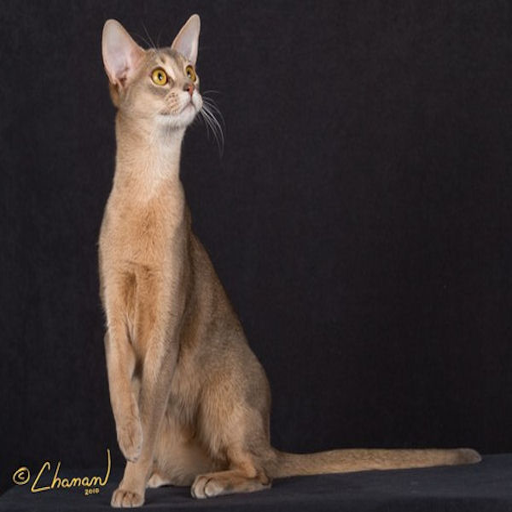

In [7]:
input_image = load_image("/home/haselab/projects/sakai/Adversarial-Perception-aware-Perturbation/data/images/Abyssinian_2.jpg", size=(512, 512))
input_image

In [11]:
prior_model_id = "kakaobrain/karlo-v1-alpha"
data_type = torch.float16
prior = PriorTransformer.from_pretrained(prior_model_id, subfolder="prior", torch_dtype=data_type)

In [12]:
prior_text_model_id = "openai/clip-vit-large-patch14"
prior_tokenizer = CLIPTokenizer.from_pretrained(prior_text_model_id)
prior_text_model = CLIPTextModelWithProjection.from_pretrained(prior_text_model_id, torch_dtype=data_type)
prior_scheduler = UnCLIPScheduler.from_pretrained(prior_model_id, subfolder="prior_scheduler")
prior_scheduler = DDPMScheduler.from_config(prior_scheduler.config)

In [14]:
stable_unclip_model_id = "stabilityai/stable-diffusion-2-1-unclip-small"

pipe = StableUnCLIPPipeline.from_pretrained(
    stable_unclip_model_id,
    torch_dtype=data_type,
    prior_tokenizer=prior_tokenizer,
    prior_text_encoder=prior_text_model,
    prior=prior,
    prior_scheduler=prior_scheduler,
)

Loading pipeline components...: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


100%|██████████| 21/21 [00:04<00:00,  4.66it/s]


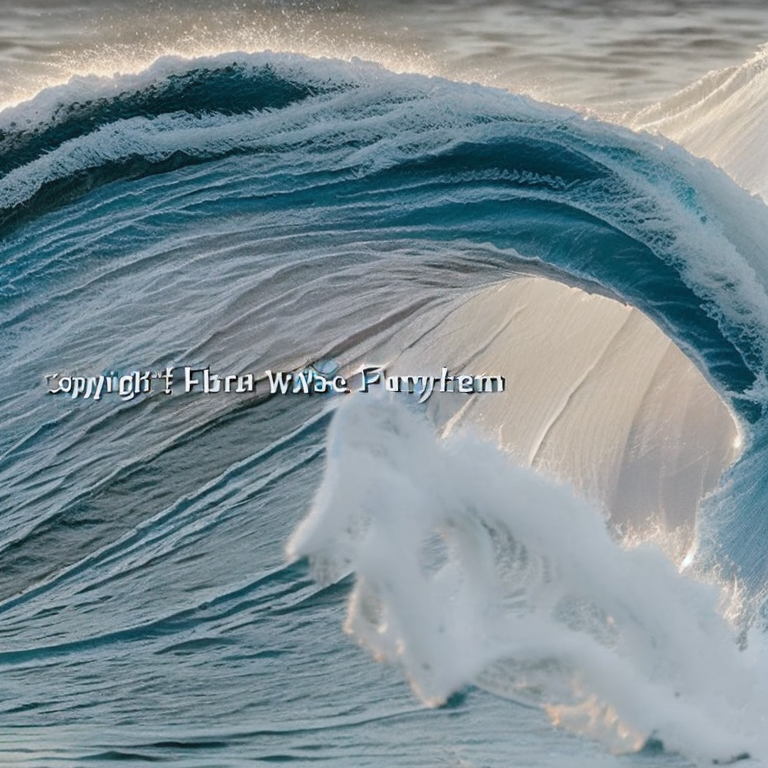

In [15]:
pipe = pipe.to("cuda")
wave_prompt = "dramatic wave, the Oceans roar, Strong wave spiral across the oceans as the waves unfurl into roaring crests; perfect wave form; perfect wave shape; dramatic wave shape; wave shape unbelievable; wave; wave shape spectacular"
image = pipe(prompt=wave_prompt).images[0]
image

In [16]:
from diffusers import StableUnCLIPImg2ImgPipeline
from diffusers.utils import load_image
import torch

pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-unclip", torch_dtype=torch.float16, variation="fp16"
)
pipe = pipe.to("cuda")

url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/stable_unclip/tarsila_do_amaral.png"
init_image = load_image(url)

images = pipe(init_image).images
images[0].save("variation_image.png")

Fetching 18 files: 100%|██████████| 18/18 [01:06<00:00,  3.67s/it]
Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.
100%|██████████| 21/21 [00:02<00:00,  8.88it/s]


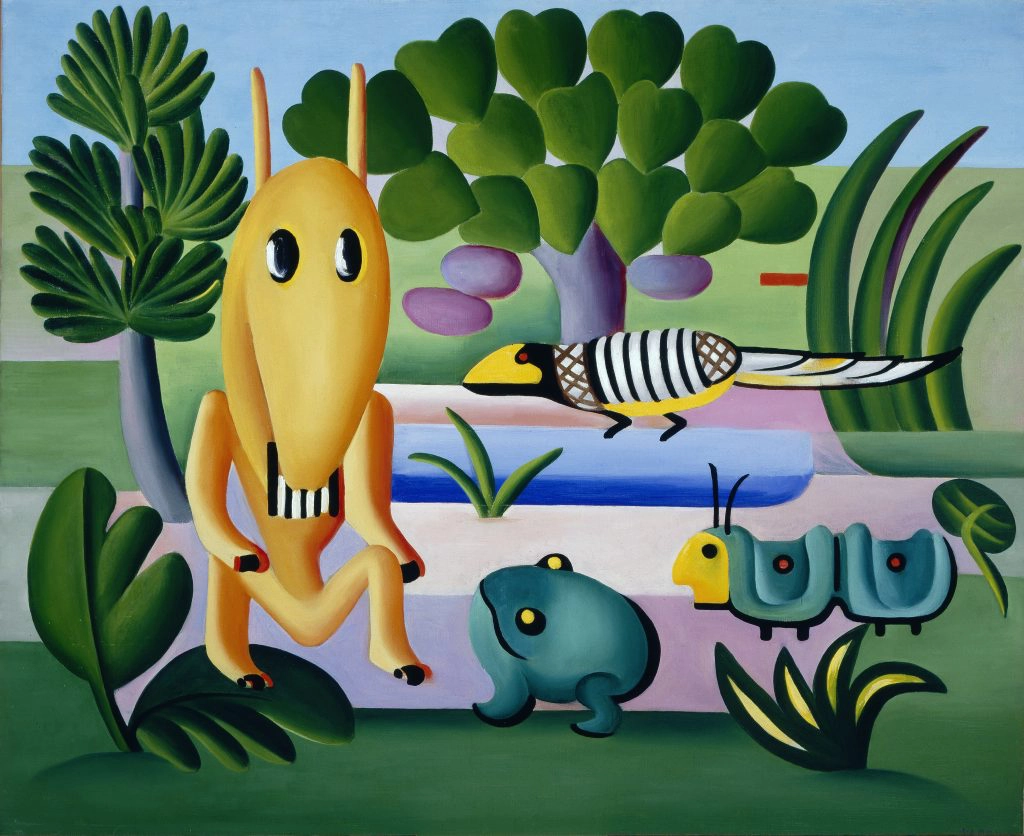

In [17]:
init_image

In [24]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableUnCLIPImg2ImgPipeline

pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-unclip-small", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
# init_image = Image.open(BytesIO(response.content)).convert("RGB")
# init_image = init_image.resize((768, 512))

init_image = input_image
prompt = ""

images = pipe(init_image, prompt).images
images[0].save("fantasy_landscape.png")

100%|██████████| 21/21 [00:02<00:00,  8.10it/s]


In [25]:
images = pipe(init_image, prompt).images
images[0].save("fantasy_landscape.png")

100%|██████████| 21/21 [00:02<00:00,  9.01it/s]


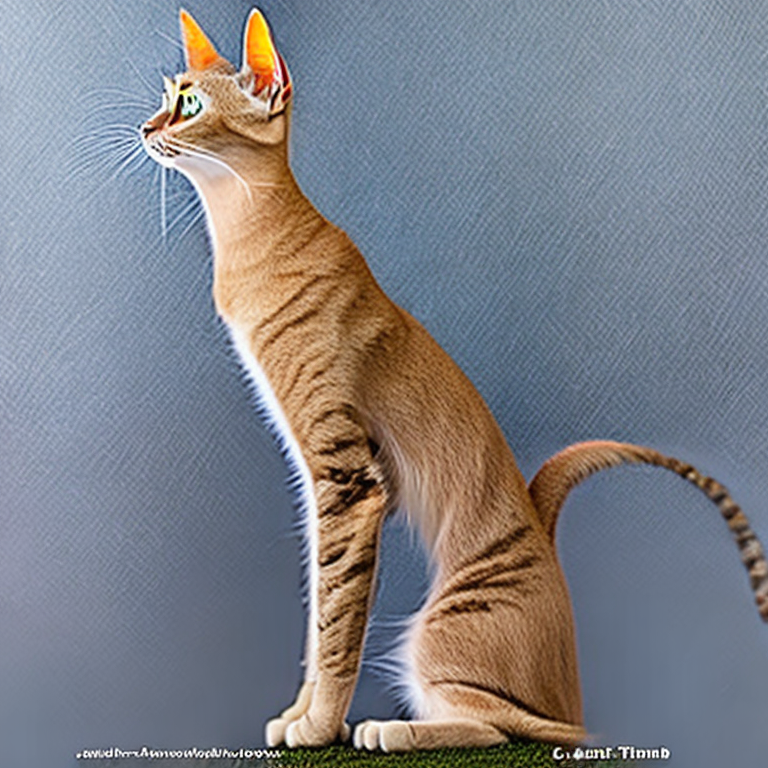

In [26]:
images[0]

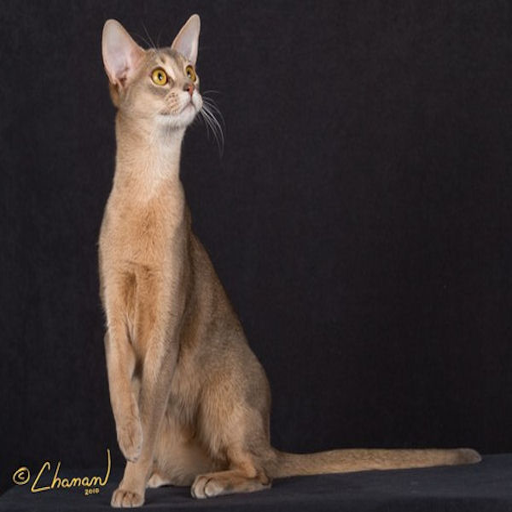

In [23]:
init_image